In [1]:
import pandas as pd
from pandas import json_normalize

from sleep_events import connect_to_firebase

db = connect_to_firebase()

docs = db.collection('erpEvents').where('experiment', '==', 'Blink').stream()
records = [doc.to_dict() for doc in docs]

df = pd.DataFrame(records)
df.head()

C:\Users\graha\.conda\envs\tf\lib\site-packages\google\cloud\firestore_v1\base_collection.py:300: UserWarning: Detected filter using positional arguments. Prefer using the 'filter' keyword argument instead.
  return query.where(field_path, op_string, value)


,timestamp,blink,experiment
0,2025-01-20 16:13:03.468000+00:00,{'eventType': 'blink'},Blink
1,2025-01-20 16:13:04.091000+00:00,{'eventType': 'blink'},Blink
2,2025-01-20 16:13:04.774000+00:00,{'eventType': 'blink'},Blink
3,2025-01-20 16:13:05.461000+00:00,{'eventType': 'blink'},Blink
4,2025-01-20 16:13:06.169000+00:00,{'eventType': 'blink'},Blink


In [2]:
input_dir = "C:\\dev\\play\\brainwave-data-day"


In [3]:
import pandas as pd
import os
from datetime import datetime, timezone

# Load the existing DataFrame with directory start times
input_dir = "C:\\dev\\play\\brainwave-data-day"
dirs = next(os.walk(input_dir))[1]

# List to store the directory names and their start times
data = []

# Iterate over the directories to extract start times
for dir_name in dirs:
    start_time = pd.to_datetime(dir_name, format='%Y-%m-%d-%H-%M-%S', utc=True)
    data.append({'dir_name': dir_name, 'start_time': start_time})

# Create a DataFrame from the data
dir_df = pd.DataFrame(data)
dir_df['start_time'] = pd.to_datetime(dir_df['start_time']).dt.tz_convert('UTC')

# Function to find the most likely file for a given timestamp
def find_file_for_timestamp(timestamp, dir_df):
    # Find the directory with the latest start time before the timestamp
    dir_df = dir_df.sort_values(by='start_time')
    for idx, row in dir_df.iterrows():
        if row['start_time'] <= timestamp:
            likely_dir = row['dir_name']
        else:
            break
    return likely_dir

# Ensure rdf['timestamp'] is timezone-aware and convert to UTC if necessary
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_convert('UTC')

# Iterate over the rows in rdf and find the corresponding file
df['likely_file'] = df['timestamp'].apply(lambda ts: find_file_for_timestamp(ts, dir_df))

# Calculate the starting sample for each row
sampling_rate = 250  # Assuming a sampling rate of 250 Hz

def calculate_starting_sample(row, dir_df):
    file_start_time = dir_df.loc[dir_df['dir_name'] == row['likely_file'], 'start_time'].iloc[0]
    time_diff = (row['timestamp'] - file_start_time).total_seconds()
    starting_sample = int(time_diff * sampling_rate)
    return starting_sample

df['starting_sample'] = df.apply(lambda row: calculate_starting_sample(row, dir_df), axis=1)

df.head()

,timestamp,blink,experiment,likely_file,starting_sample
0,2025-01-20 16:13:03.468000+00:00,{'eventType': 'blink'},Blink,2025-01-20-15-40-00,495867
1,2025-01-20 16:13:04.091000+00:00,{'eventType': 'blink'},Blink,2025-01-20-15-40-00,496022
2,2025-01-20 16:13:04.774000+00:00,{'eventType': 'blink'},Blink,2025-01-20-15-40-00,496193
3,2025-01-20 16:13:05.461000+00:00,{'eventType': 'blink'},Blink,2025-01-20-15-40-00,496365
4,2025-01-20 16:13:06.169000+00:00,{'eventType': 'blink'},Blink,2025-01-20-15-40-00,496542


In [4]:
likely_files = df['likely_file'].unique()
likely_files

array(['2025-01-20-15-40-00', '2025-01-20-18-30-48'], dtype=object)

In [5]:
from convert import load_mne_file
import os
import pandas as pd

# Initialize an empty dictionary to store the files
file_map = {}

# Iterate over the unique likely files
for file_name in likely_files:
    # Construct the full path to the file
    file_path = os.path.join(input_dir, file_name, "raw.fif")

    # Check if the file exists
    if os.path.exists(file_path):
        # Load the file and store it in the map

        raw, _, filtered = load_mne_file(print, file_path)
        file_map[file_name] = filtered

# Display the keys of the map to verify
print(file_map.keys())

Reading file C:\dev\play\brainwave-data-day\2025-01-20-15-40-00\raw.fif
Opening raw data file C:\dev\play\brainwave-data-day\2025-01-20-15-40-00\raw.fif...
Isotrak not found
    Range : 0 ... 501658 =      0.000 ...  2006.632 secs
Ready.
Reading 0 ... 501658  =      0.000 ...  2006.632 secs...
Finished reading file C:\dev\play\brainwave-data-day\2025-01-20-15-40-00\raw.fif
Reading file C:\dev\play\brainwave-data-day\2025-01-20-18-30-48\raw.fif
Opening raw data file C:\dev\play\brainwave-data-day\2025-01-20-18-30-48\raw.fif...
Isotrak not found
    Range : 0 ... 20834 =      0.000 ...    83.336 secs
Ready.
Reading 0 ... 20834  =      0.000 ...    83.336 secs...
Finished reading file C:\dev\play\brainwave-data-day\2025-01-20-18-30-48\raw.fif
dict_keys(['2025-01-20-15-40-00', '2025-01-20-18-30-48'])


In [6]:
def get_data_for_row(row, file_map, minus = 250, plus = 250):
    file = row['likely_file']
    fif = file_map[file]
    data = fif.get_data(units='uV')
    interesting_data = data[0][row['starting_sample'] - minus:row['starting_sample'] + plus]
    # interesting_data = data[0][row['starting_sample'] - (250 * 5):row['starting_sample'] + (250 * 5)]
    return interesting_data

get_data_for_row(df.iloc[1], file_map).shape

(500,)

In [7]:
df['sample_diff'] = df['starting_sample'] - df['starting_sample'].shift(1)

In [8]:
df

,timestamp,blink,experiment,likely_file,starting_sample,sample_diff
0,2025-01-20 16:13:03.468000+00:00,{'eventType': 'blink'},Blink,2025-01-20-15-40-00,495867,NaN
1,2025-01-20 16:13:04.091000+00:00,{'eventType': 'blink'},Blink,2025-01-20-15-40-00,496022,155.0
2,2025-01-20 16:13:04.774000+00:00,{'eventType': 'blink'},Blink,2025-01-20-15-40-00,496193,171.0
3,2025-01-20 16:13:05.461000+00:00,{'eventType': 'blink'},Blink,2025-01-20-15-40-00,496365,172.0
4,2025-01-20 16:13:06.169000+00:00,{'eventType': 'blink'},Blink,2025-01-20-15-40-00,496542,177.0
5,2025-01-20 16:13:06.921000+00:00,{'eventType': 'blink'},Blink,2025-01-20-15-40-00,496730,188.0
6,2025-01-20 16:13:08.164000+00:00,{'eventType': 'blink'},Blink,2025-01-20-15-40-00,497041,311.0
7,2025-01-20 16:13:09.666000+00:00,{'eventType': 'blink'},Blink,2025-01-20-15-40-00,497416,375.0
8,2025-01-20 16:13:11.430000+00:00,{'eventType': 'blink'},Blink,2025-01-20-15-40-00,497857,441.0
9,2025-01-20 16:13:11.772000+00:00,{'eventType': 'blink'},Blink,2025-01-20-15-40-00,497943,86.0


In [11]:
double_blinks = df[(df['sample_diff'] > 0) & (df['sample_diff'] < 100)]

In [12]:
double_blinks

,timestamp,blink,experiment,likely_file,starting_sample,sample_diff
9,2025-01-20 16:13:11.772000+00:00,{'eventType': 'blink'},Blink,2025-01-20-15-40-00,497943,86.0
20,2025-01-20 18:31:52.611000+00:00,{'eventType': 'blink'},Blink,2025-01-20-18-30-48,16152,43.0
22,2025-01-20 18:31:56.246000+00:00,{'eventType': 'blink'},Blink,2025-01-20-18-30-48,17061,70.0
24,2025-01-20 18:31:59.907000+00:00,{'eventType': 'blink'},Blink,2025-01-20-18-30-48,17976,57.0
26,2025-01-20 18:32:02.868000+00:00,{'eventType': 'blink'},Blink,2025-01-20-18-30-48,18717,51.0
28,2025-01-20 18:32:05.303000+00:00,{'eventType': 'blink'},Blink,2025-01-20-18-30-48,19325,77.0


In [9]:
double_blink = df.iloc[8]
double_blink

timestamp          2025-01-20 16:13:11.430000+00:00
blink                        {'eventType': 'blink'}
experiment                                    Blink
likely_file                     2025-01-20-15-40-00
starting_sample                              497857
sample_diff                                   441.0
Name: 8, dtype: object

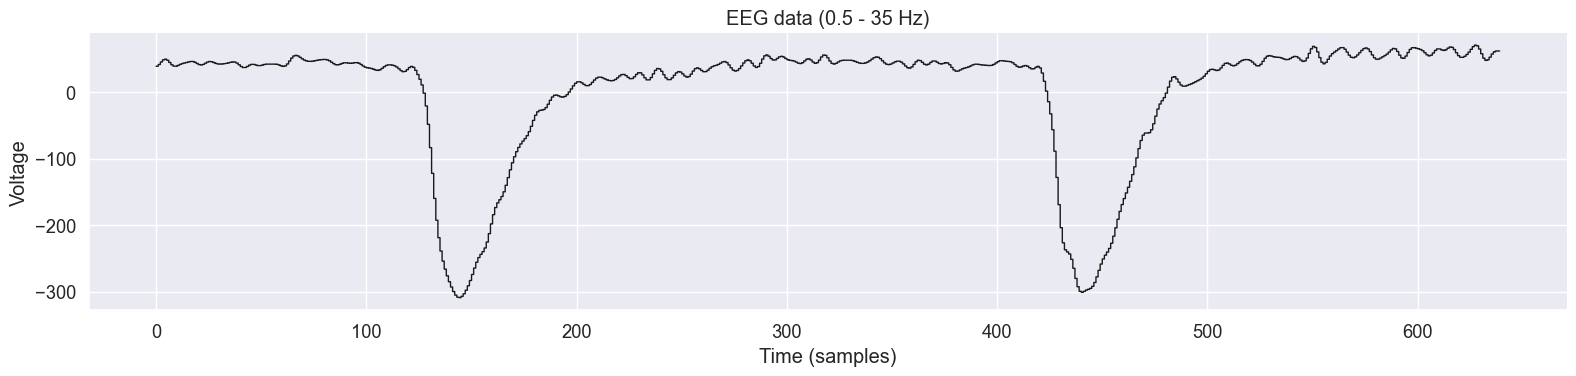

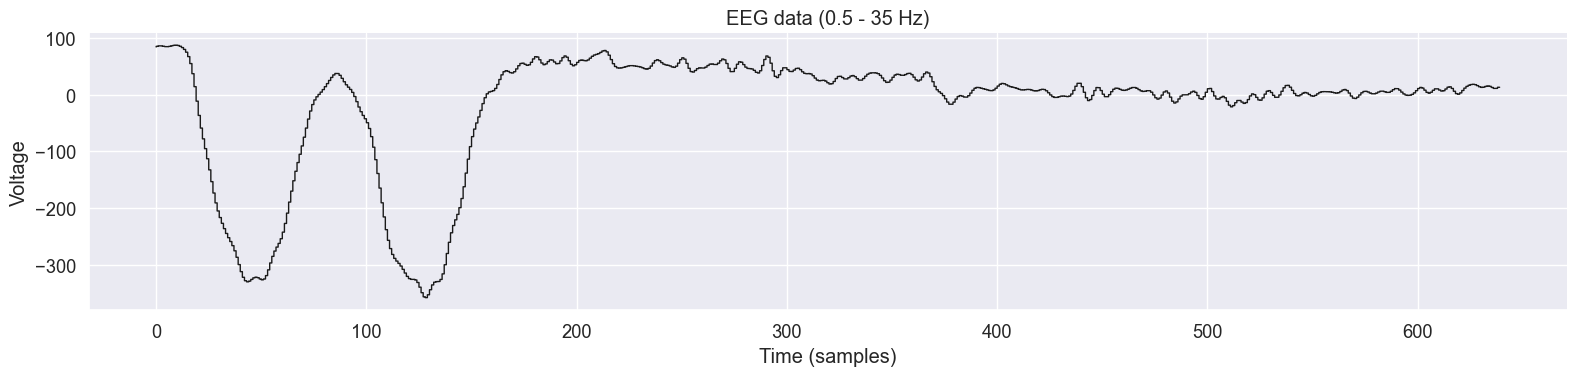

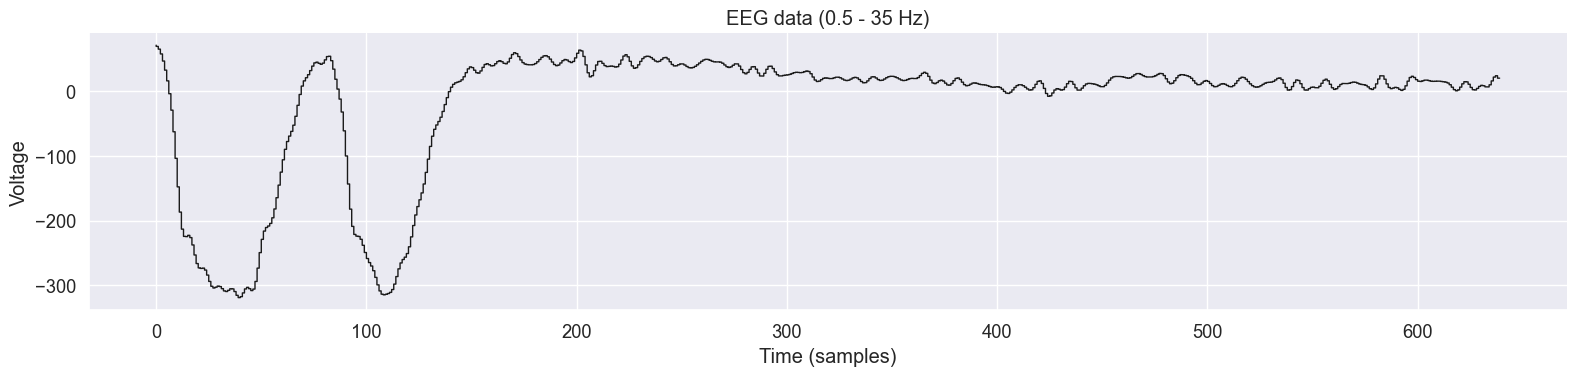

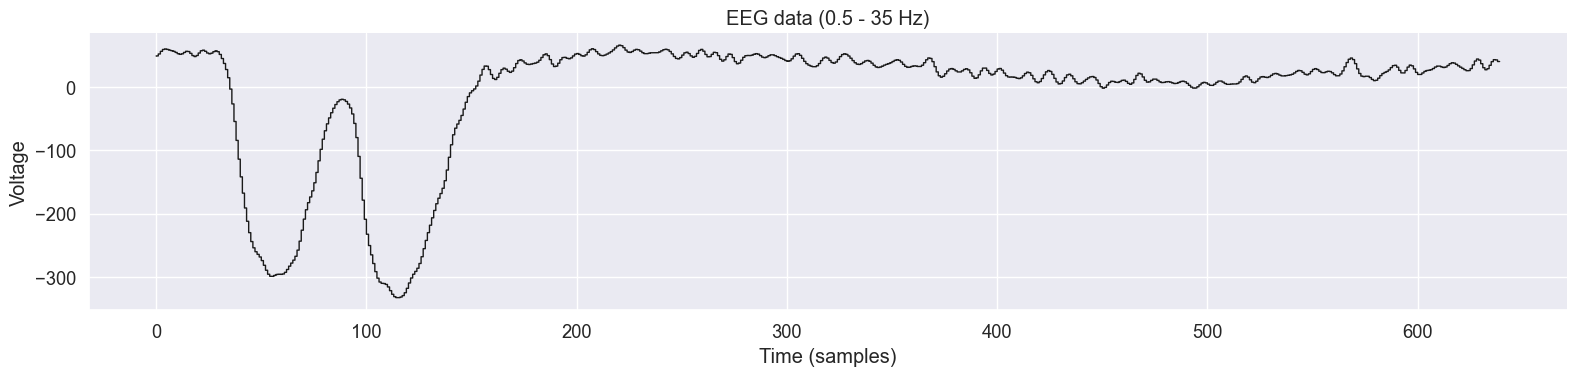

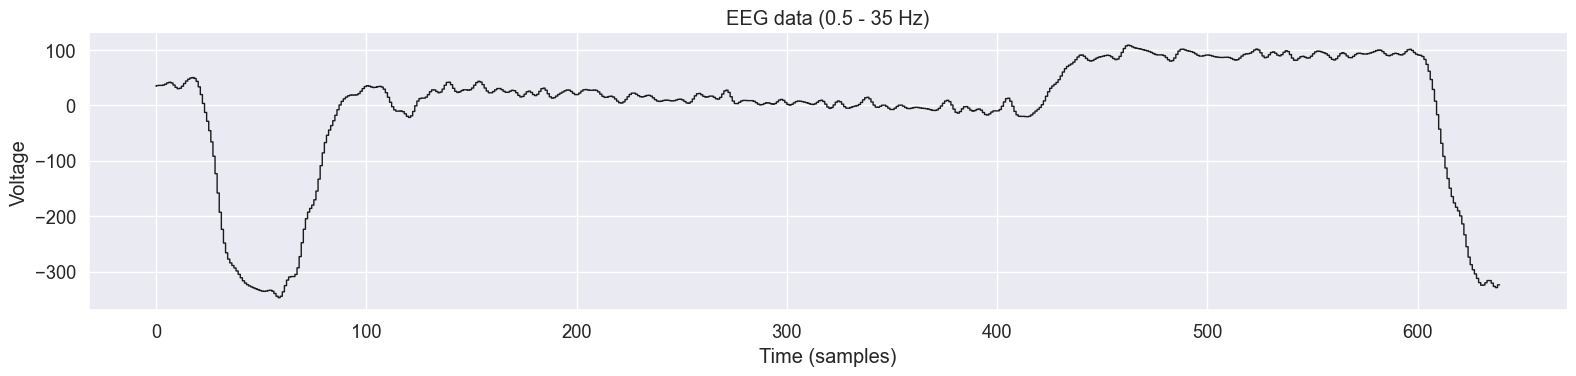

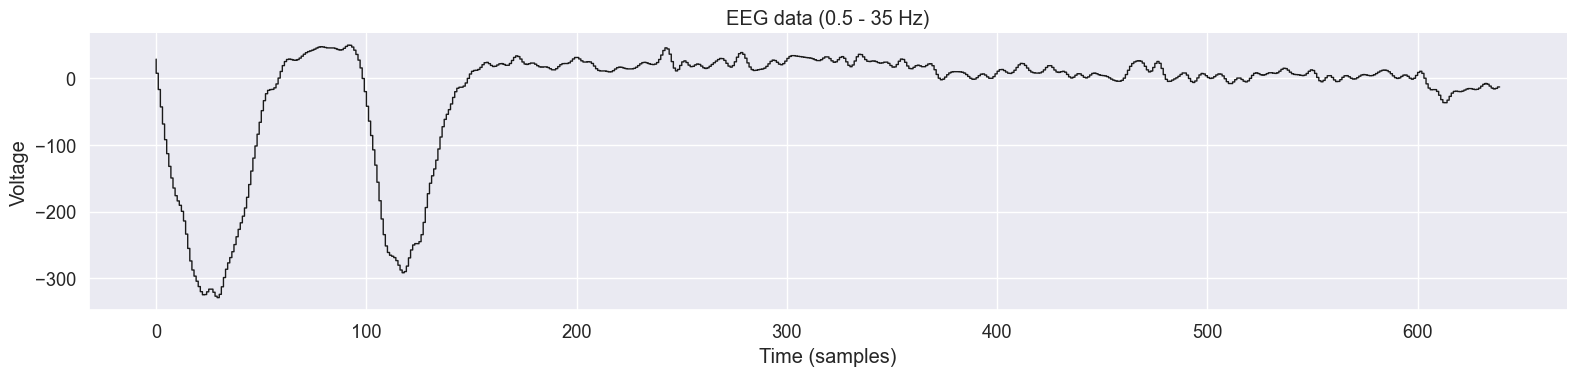

In [23]:
from notebooks.Util.DrawEpochs import plot_eeg_data

for _, db in double_blinks.iterrows():
    double_blink_data = get_data_for_row(db, file_map, 140
                                         , 500)
    plot_eeg_data(double_blink_data)

In [10]:
double_blink_data = get_data_for_row(double_blink, file_map, 500, -300)
plot_eeg_data(double_blink_data)

NameError: name 'plot_eeg_data' is not defined

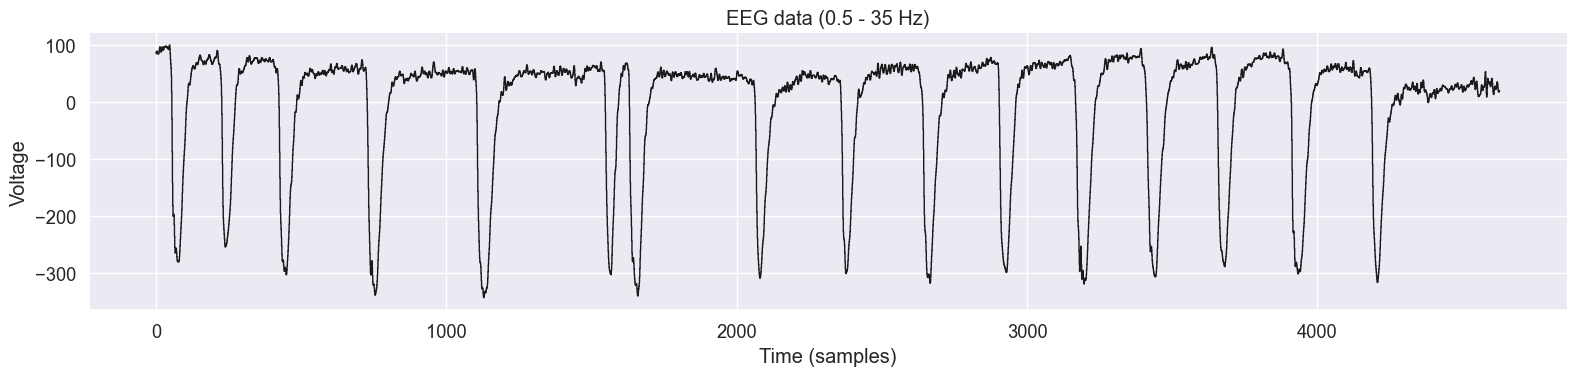

In [30]:
start_idx = df.iloc[0]['starting_sample']
end_idx = df.iloc[len(df) - 1]['starting_sample']
fif = file_map[list(file_map.keys())[0]]
data = fif.get_data(units='uV')
data = data[0][start_idx:end_idx]
plot_eeg_data(data)

In [28]:
data[0].shape

(501659,)

In [27]:
(end_idx - start_idx) / 250

18.516

NameError: name 'start_idx' is not defined

In [14]:
interesting = df


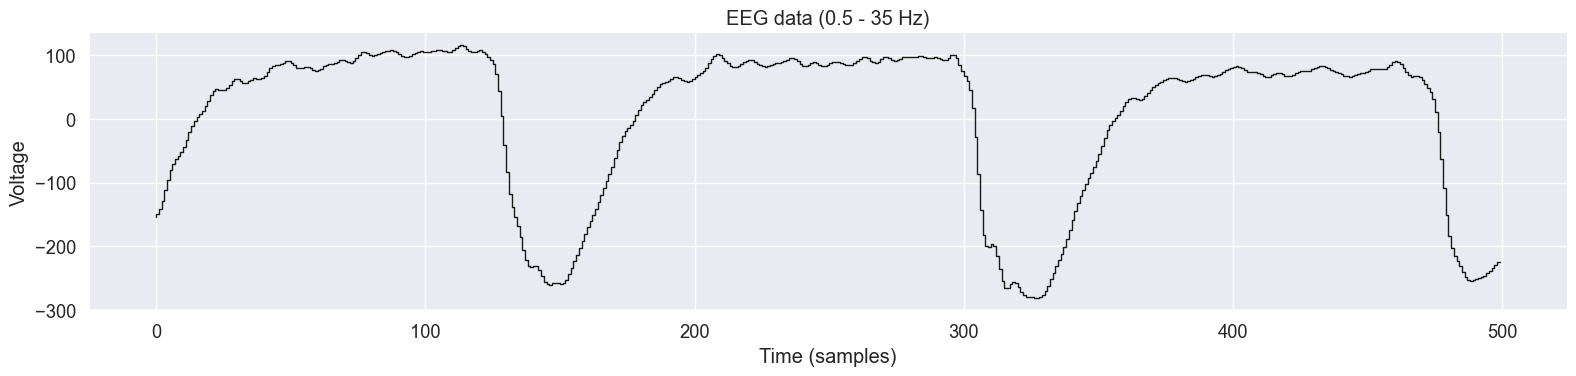

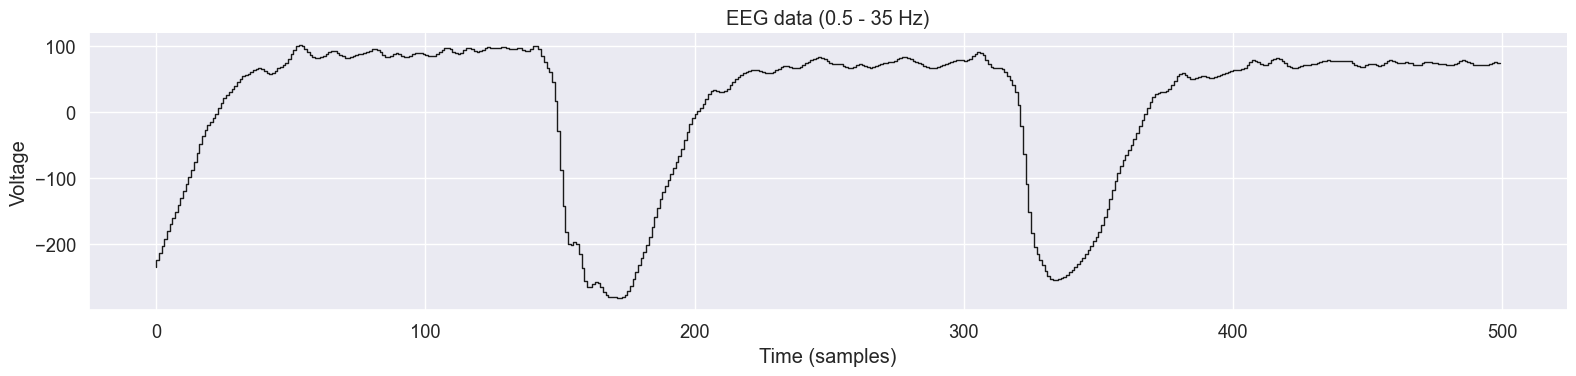

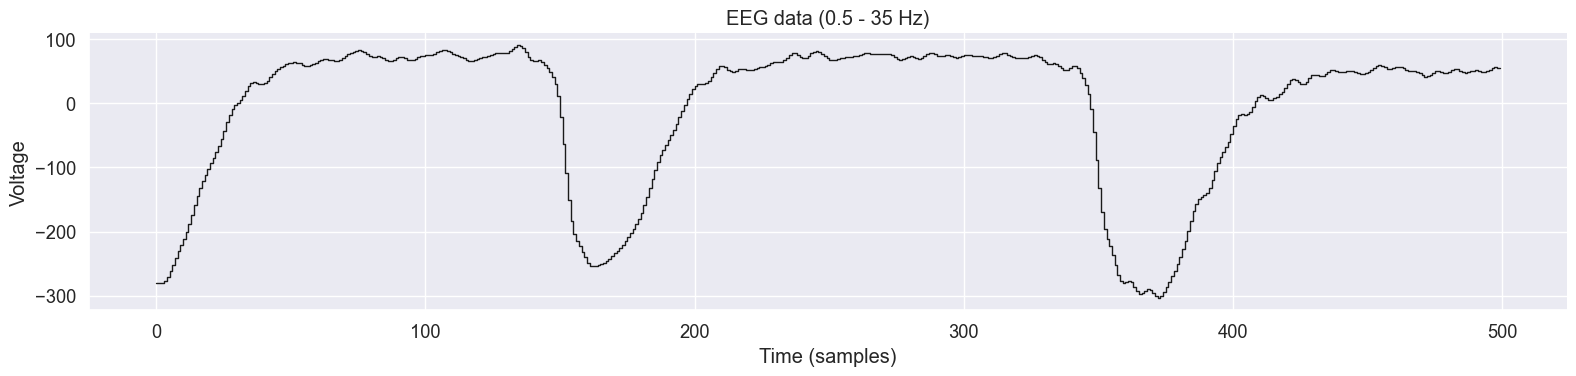

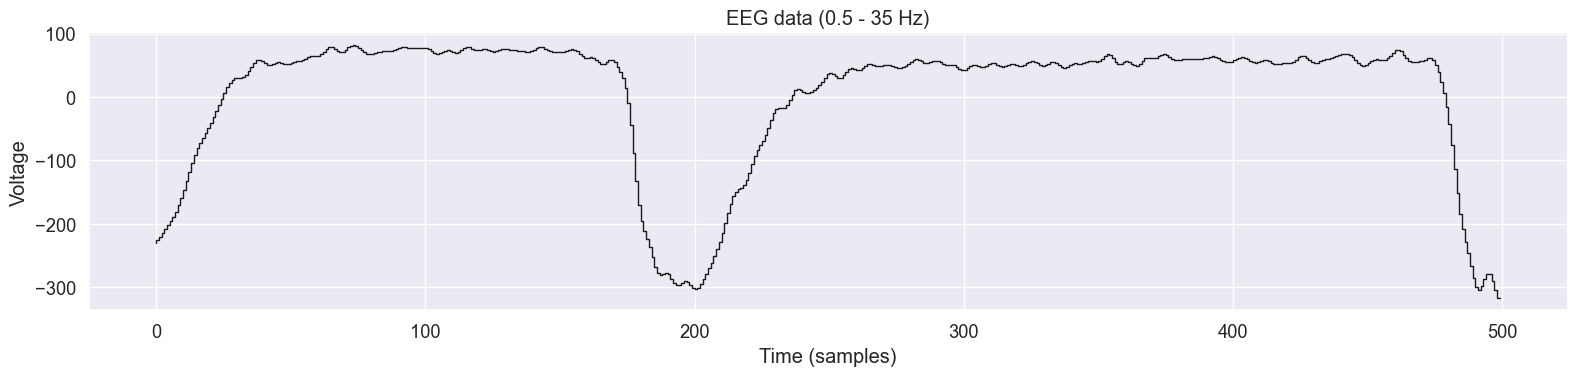

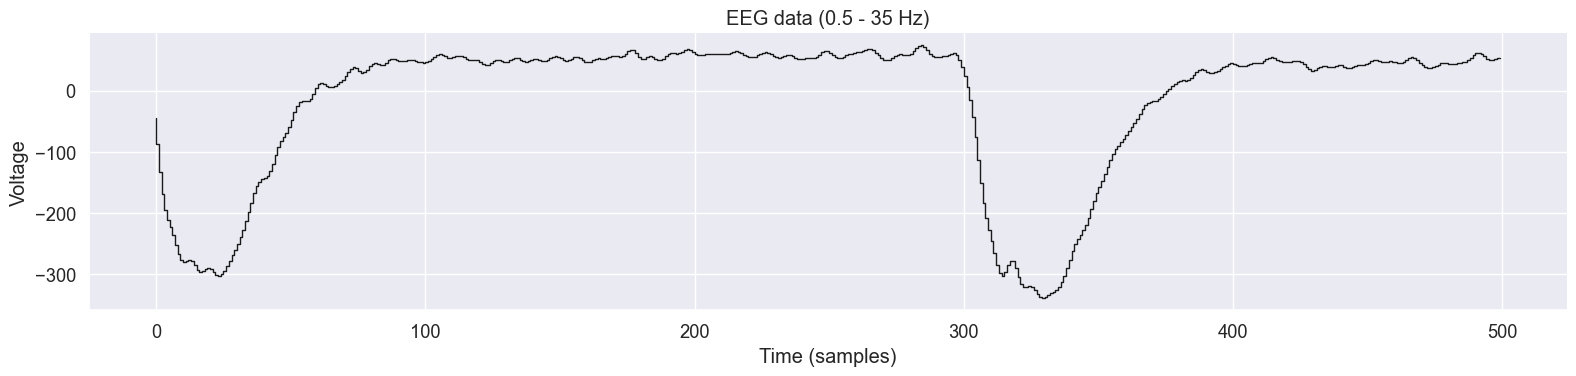

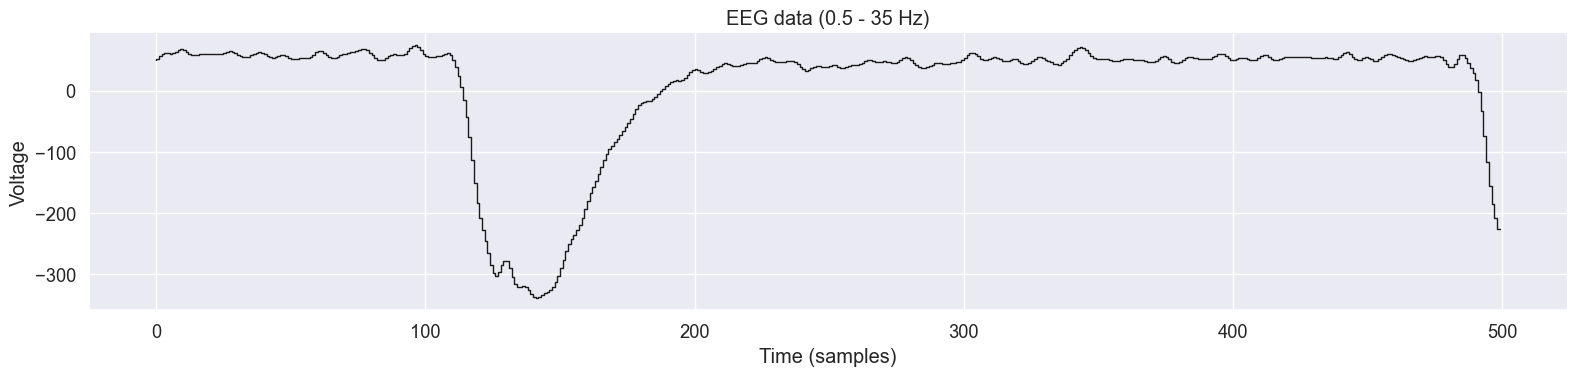

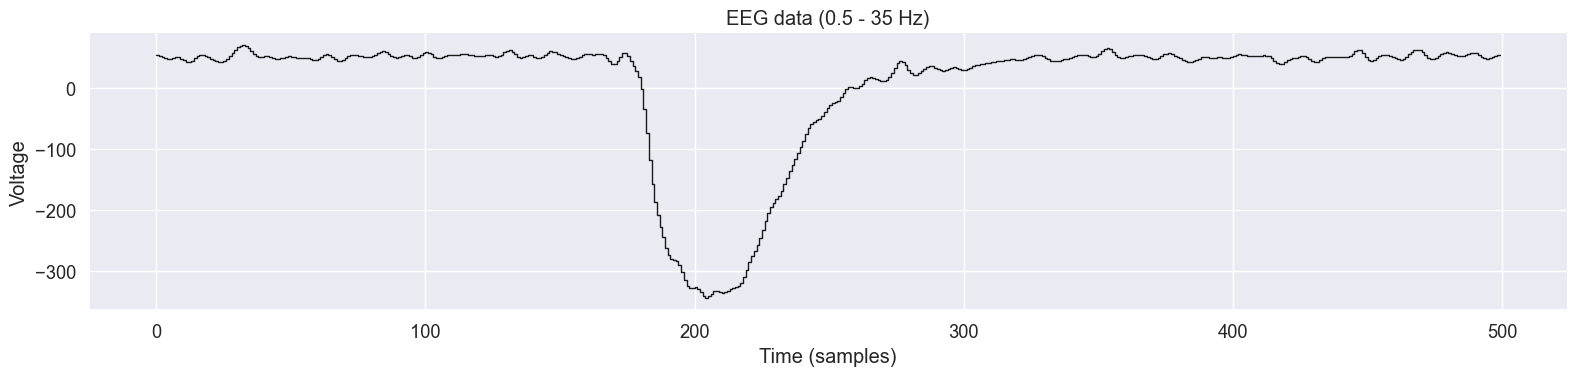

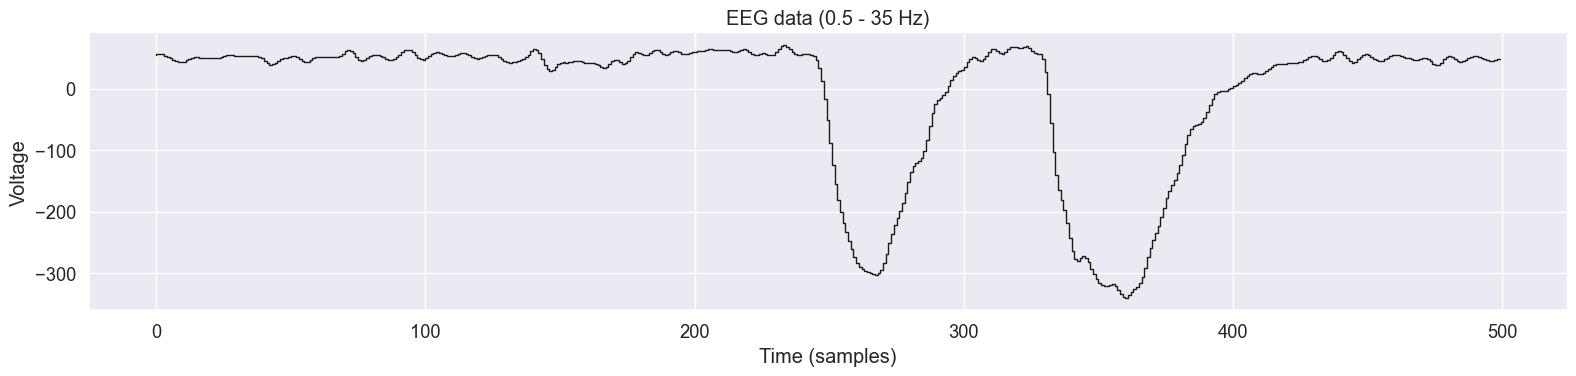

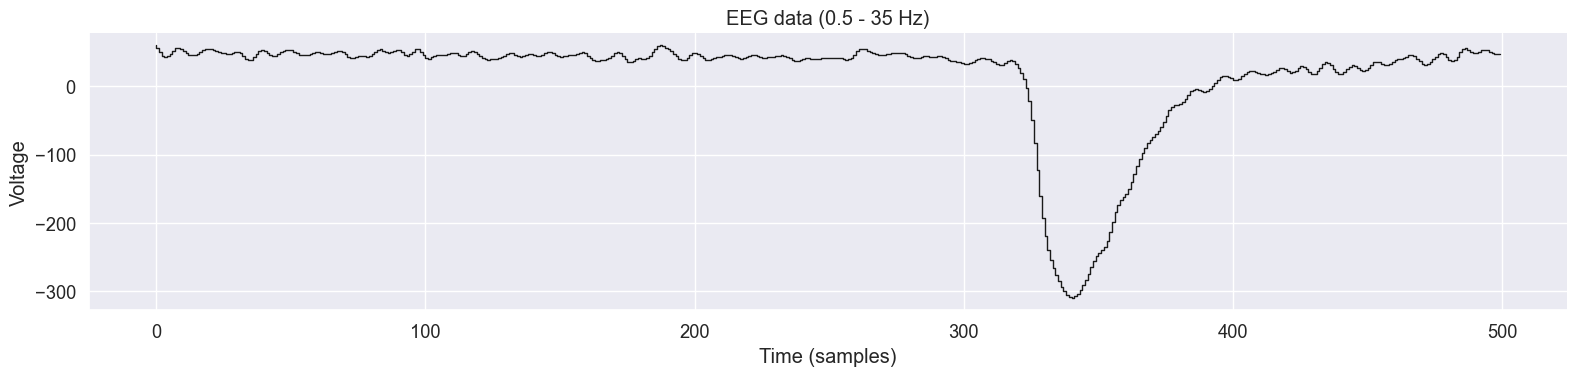

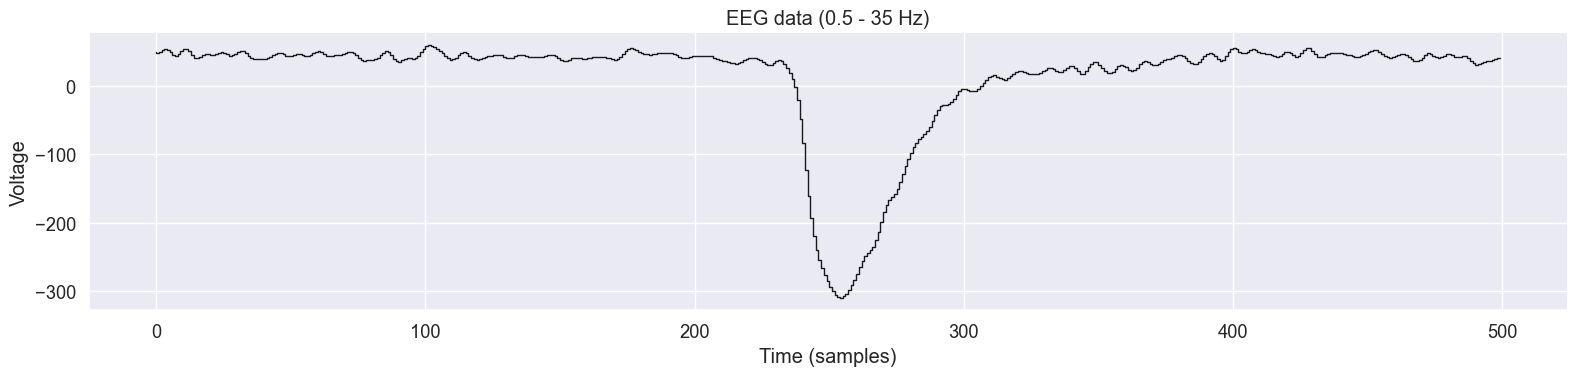

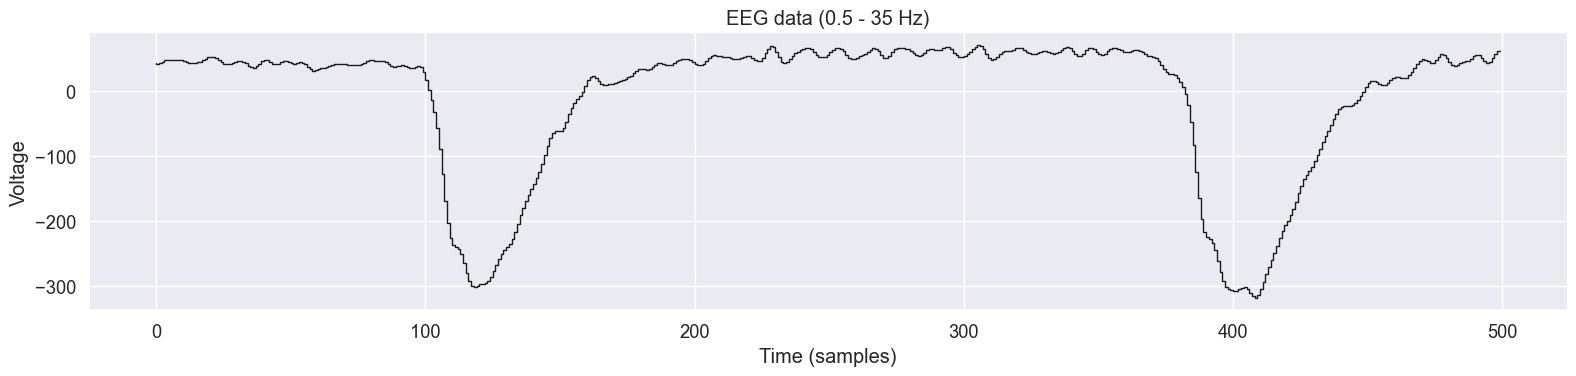

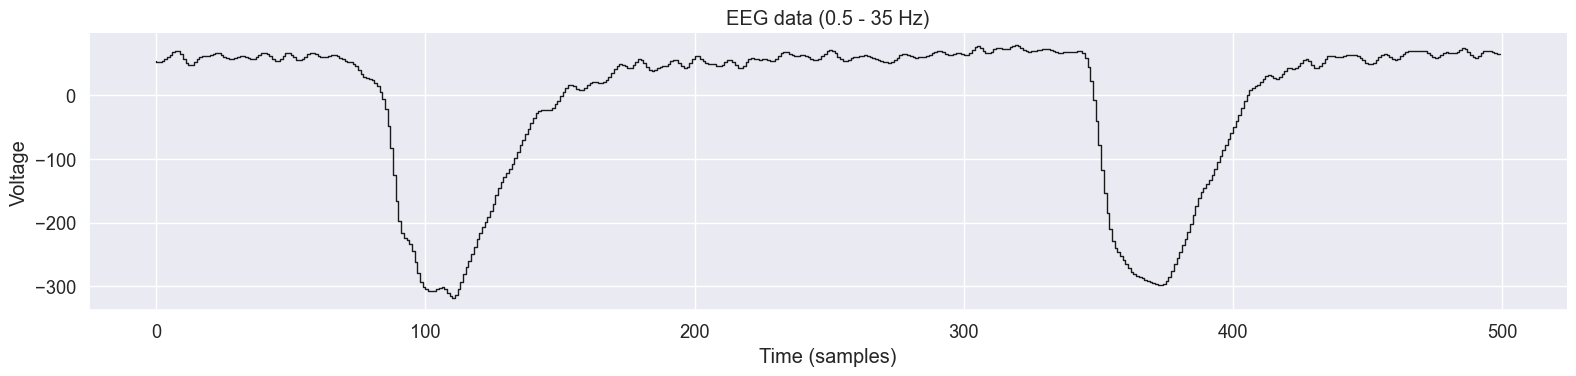

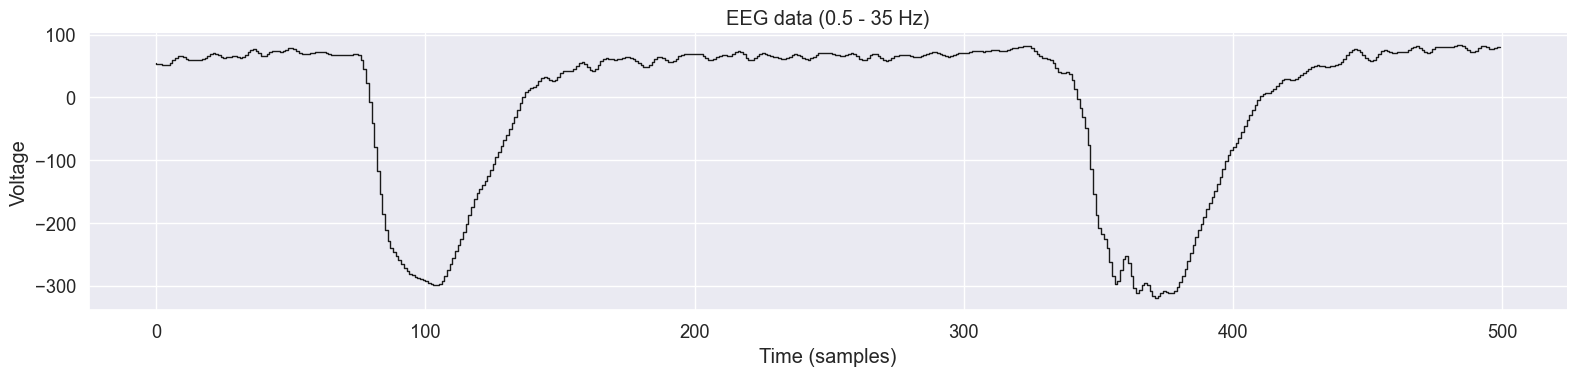

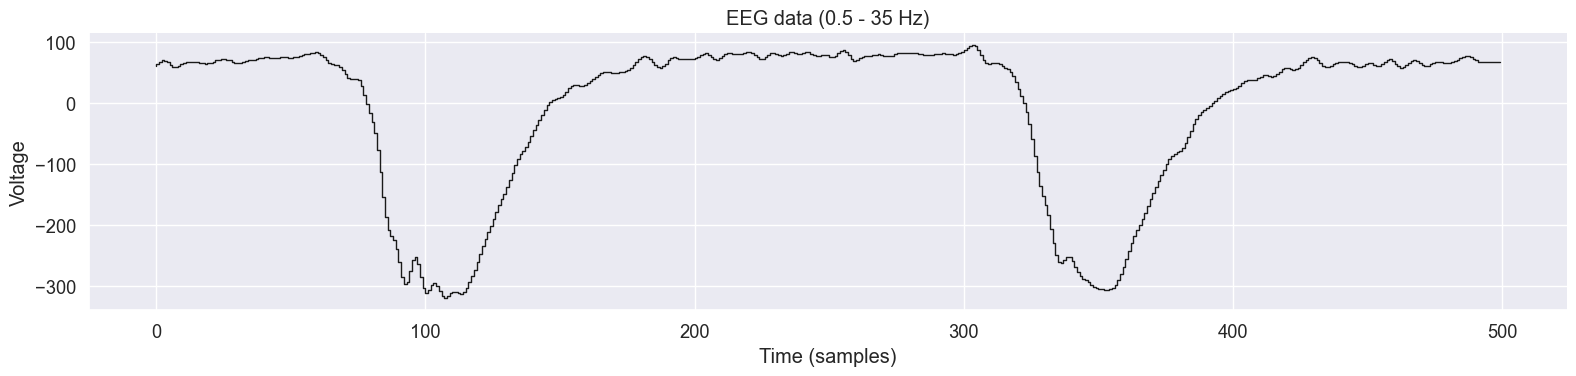

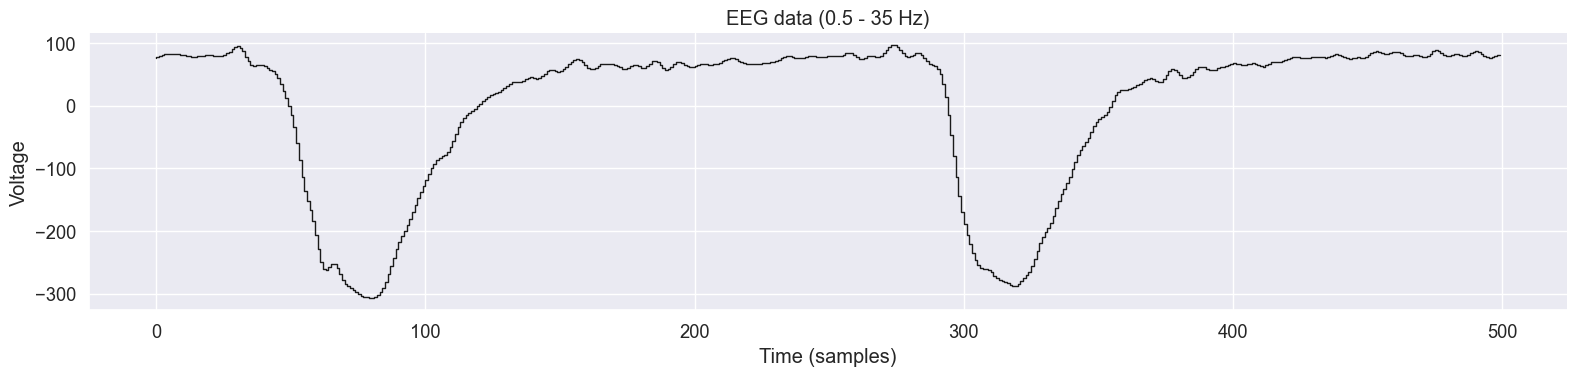

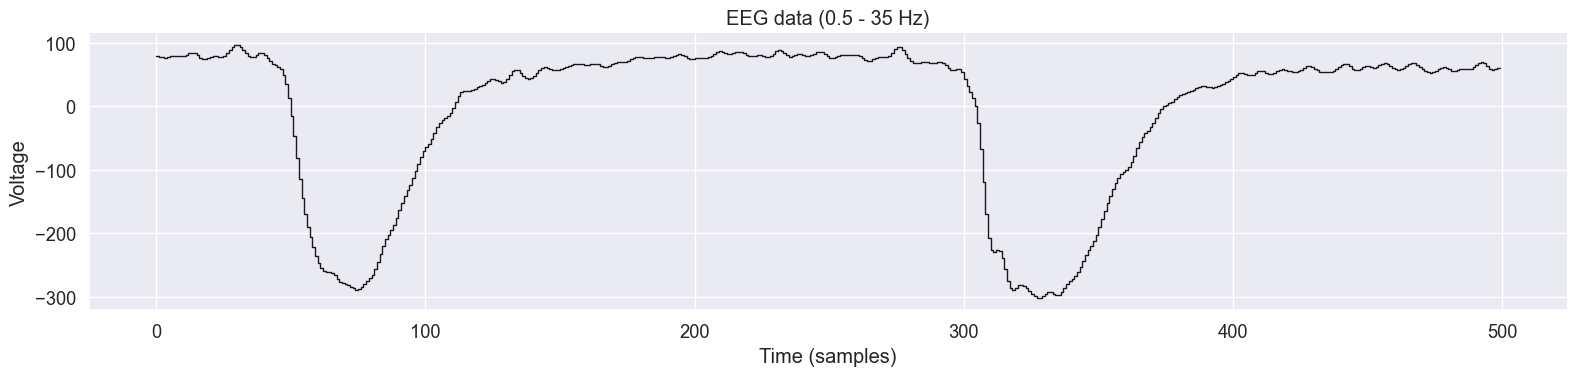

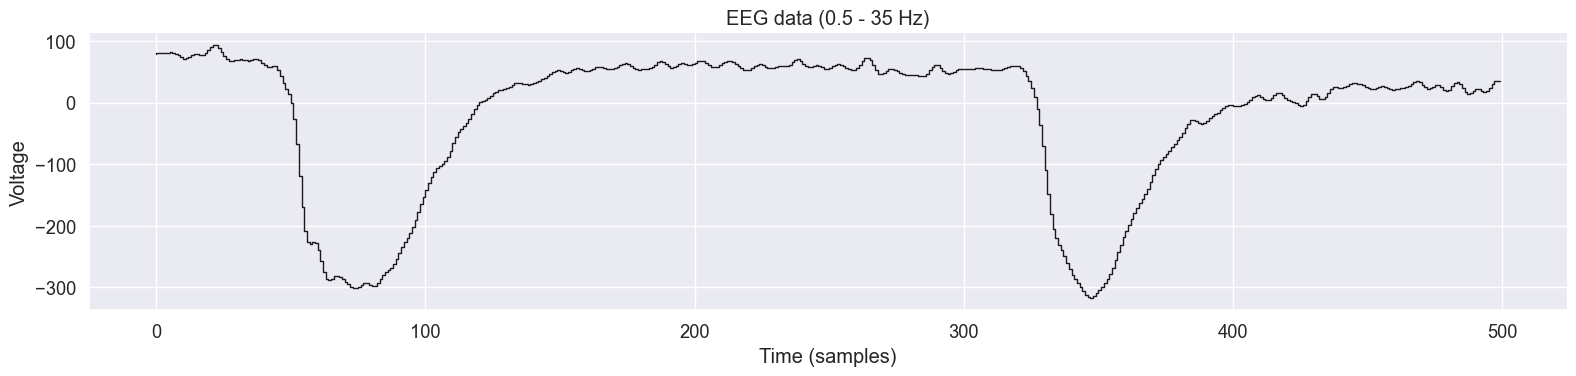

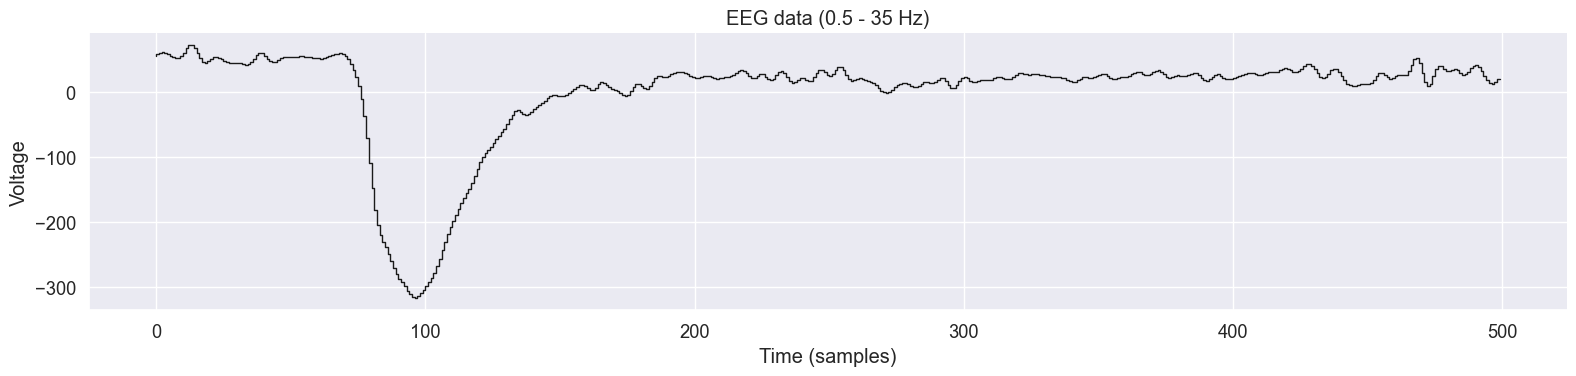

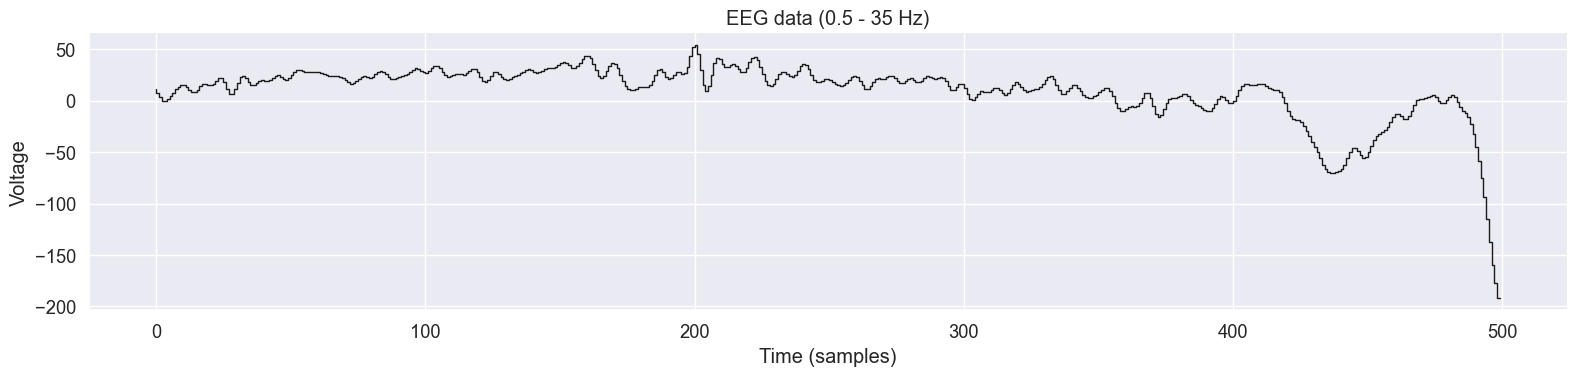

In [15]:

from notebooks.Util.DrawEpochs import plot_eeg_data

for _, row in interesting.iterrows():
    data = get_data_for_row(row, file_map)
    plot_eeg_data(data)


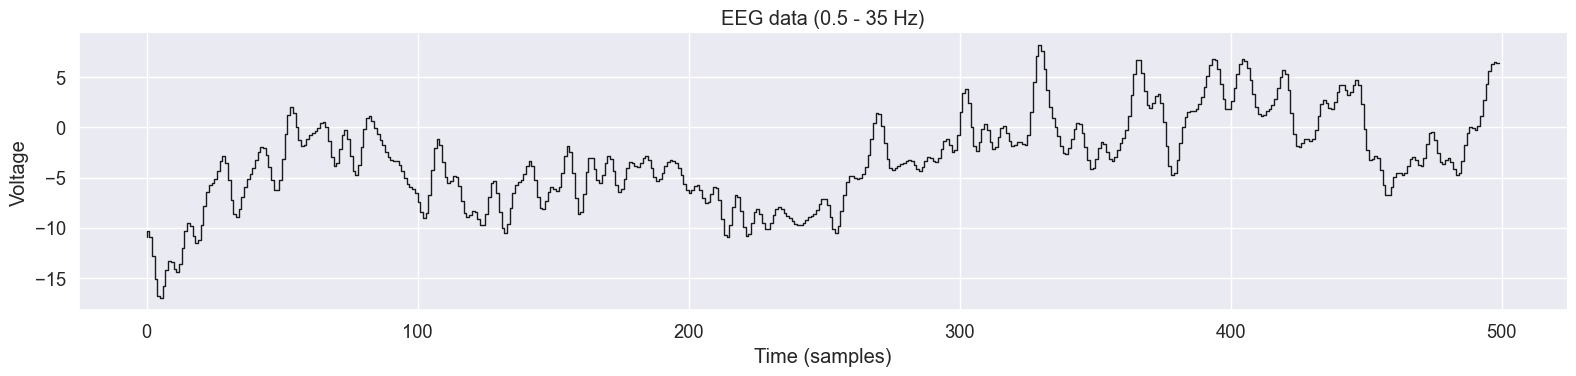

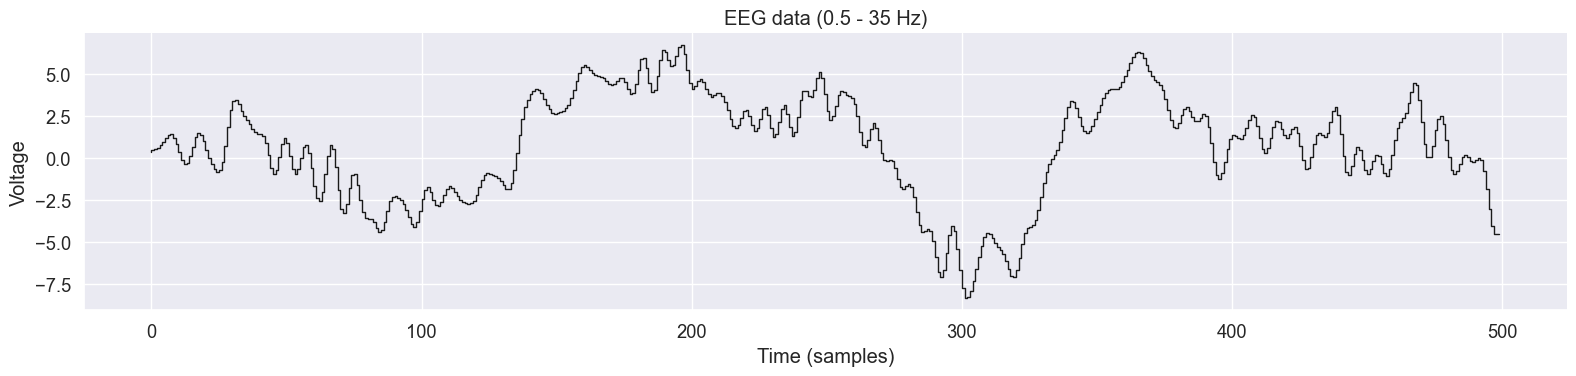

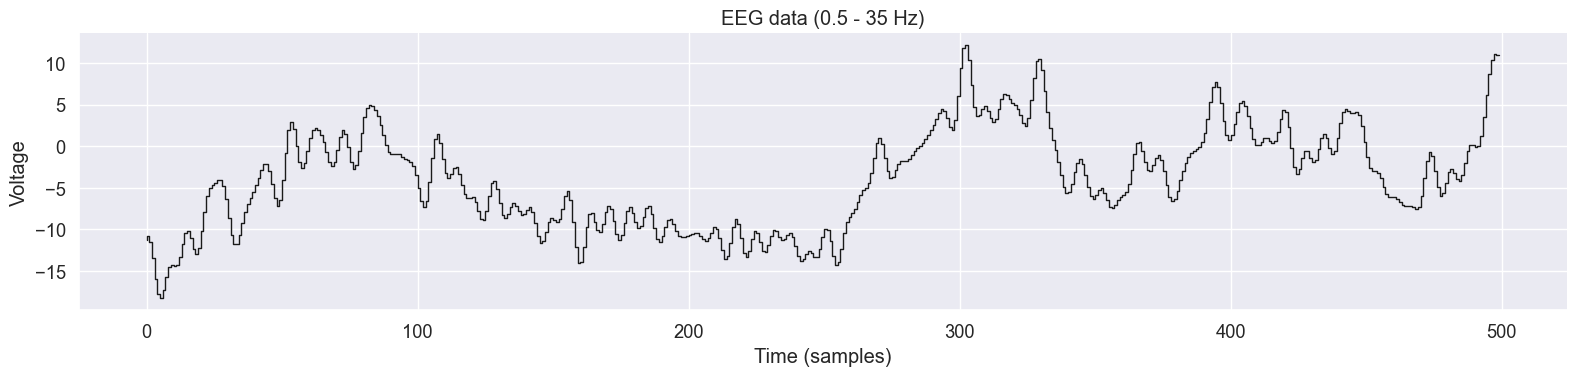

In [109]:
import numpy as np

def get_average_data_for_rows(rows, file_map):
    all_data = []
    for _, row in rows.iterrows():
        data = get_data_for_row(row, file_map)
        all_data.append(data)
    all_data_array = np.array(all_data)
    average_data = np.mean(all_data_array, axis=0)
    return average_data

average_deviant = get_average_data_for_rows(deviant, file_map)
average_standard = get_average_data_for_rows(standard, file_map)

average_diff = average_deviant - average_standard

plot_eeg_data(average_deviant)
plot_eeg_data(average_standard)
plot_eeg_data(average_diff)


In [64]:
fif = file_map['2025-01-20-08-26-13']
data = fif.get_data(units='uV')

In [53]:
type(data)

numpy.ndarray

In [68]:
interesting_data = data[0][rdf.iloc[1]['starting_sample'] - 250:rdf.iloc[1]['starting_sample'] + 250]
interesting_data.shape

(500,)

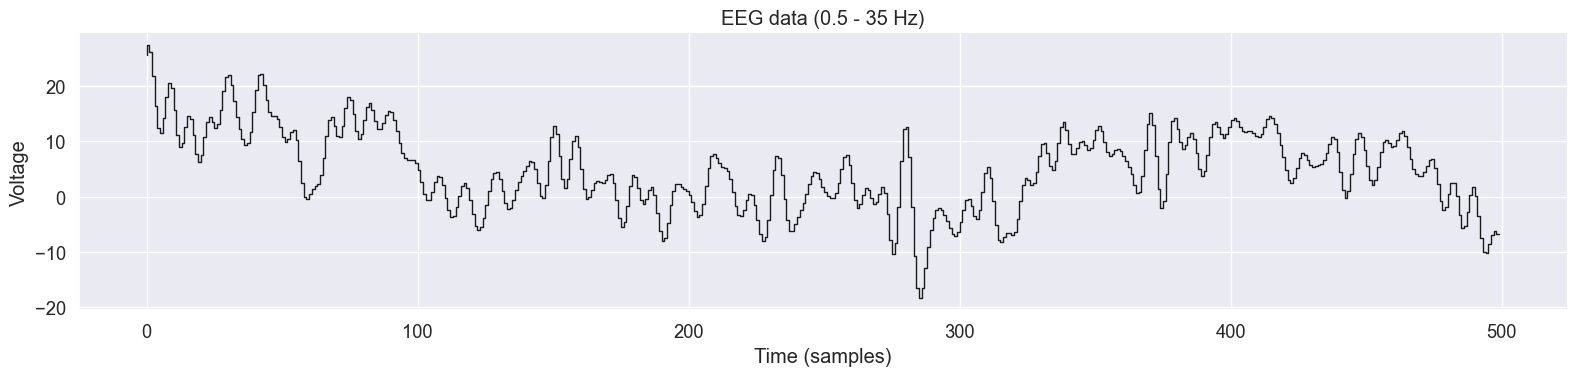

In [69]:
from notebooks.Util.DrawEpochs import plot_eeg_data

plot_eeg_data(interesting_data)